In [1]:
from itertools import product
from numpy import array, zeros, newaxis, allclose, eye, diag, unique
from numpy.linalg import inv, eig

The following matrices, vectors, were produced using `random_Q()`, `random_triple_J()` functions from earlier code you provided.

In [2]:
Pa = array([[0.71893144, 0.14144765, 0.10698649, 0.03263443],
       [0.06325843, 0.77423272, 0.13928361, 0.02322523],
       [0.02322523, 0.13928361, 0.77423272, 0.06325843],
       [0.03263443, 0.10698649, 0.14144765, 0.71893144]])

Pb = array([[0.95154866, 0.01674797, 0.0234783 , 0.00822507],
       [0.03863562, 0.84803839, 0.04732459, 0.0660014 ],
       [0.0660014 , 0.04732459, 0.84803839, 0.03863562],
       [0.00822507, 0.0234783 , 0.01674797, 0.95154866]])

Pc = array([[0.88137945, 0.04613594, 0.02686734, 0.04561727],
       [0.05009116, 0.9236776 , 0.0194023 , 0.00682894],
       [0.00682894, 0.0194023 , 0.9236776 , 0.05009116],
       [0.04561727, 0.02686734, 0.04613594, 0.88137945]])
Pm = array([[0.81203158, 0.04399917, 0.07848442, 0.06548484],
       [0.08284662, 0.87115553, 0.02024715, 0.0257507 ],
       [0.0257507 , 0.02024715, 0.87115553, 0.08284662],
       [0.06548484, 0.07848442, 0.04399917, 0.81203158]])

pi = array([0.14977394, 0.26317362, 0.39165429, 0.19539816])

pi_m = pi @ Pm

J = array([[[0.07508613297288518, 0.00466350788803318, 0.0033432901131033796, 0.004042219322757277], [0.002186937387234338, 0.01570096614179908, 0.0011254388766303509, 0.0005015574893929194], [0.002007283482847851, 0.0012535337368050612, 0.013395860029779497, 0.0010220788989917808], [0.0013011086711092986, 0.0016042909684947522, 0.0012404869820179004, 0.011323417297654589]], [[0.03129698648252512, 0.00815953485072002, 0.004394876926278819, 0.0020308813605868174], [0.008288184321098279, 0.14201837079233715, 0.005398759767993272, 0.0017880581744532536], [0.0015277493099248596, 0.00886482820182737, 0.04269081732021271, 0.0028169181161841477], [0.0021015052010260205, 0.011819352252411985, 0.0034103593745217937, 0.02379160092199082]], [[0.02174460265532043, 0.002941403304710777, 0.017006110729978843, 0.0023681733984058486], [0.0022577498981608663, 0.03237071808690972, 0.012426756488990255, 0.0019160961759307586], [0.0022144999652547693, 0.006239396030284971, 0.20953281339937846, 0.012130269098422072], [0.002543170970124578, 0.003973434481032667, 0.011775618913078878, 0.04210892174683528]], [[0.012093125924573445, 0.0012993605630256348, 0.0021464967072447926, 0.0015645368675293004], [0.0010702747292501203, 0.013479197587703494, 0.0016493822206027895, 0.0025896804160072057], [0.0005894417935184289, 0.00127918145334602, 0.022260289874459077, 0.0029430040436876307], [0.005229012301832341, 0.0040480932067737535, 0.006152859243062461, 0.09785943409093556]]])

now checking my understanding of computing joint probabilities for the two ingroups is correct

In [3]:
J_mb = pi_m[:, newaxis] * Pb
J_bc = J_mb.T @ Pc
J_ab = Pa.T @ diag(pi) @ Pm @ Pb
J_ca = (Pa.T @ diag(pi) @ Pm @ Pc).T

assert allclose(J_bc, J.sum(axis=0))  # checking I have constructed it correctly
assert allclose(J_ab, J.sum(axis=2))
assert allclose(J_ca, J.sum(axis=1).T)

In [4]:
def get_P_mx(J):
    """return matrix for Pmx from Joint prob matrix"""
    S = eye(4)[::-1]  # nice
    PSP = S @ inv(J) @ S @ J
    _, P = eig(PSP.T)
    P = P.T
    P = diag(1/P.sum(axis=1)) @ P
    dlc_ix = P.argmax(axis=0)
    assert len(unique(dlc_ix)) == 4, 'DLC fail'
    return P[dlc_ix]

P_est = get_P_mx(J_bc)
other_P_est = (J_bc @ inv(P_est)).T
pi_est = other_P_est.sum(axis=1)
other_P_est = diag(1/pi_est) @ other_P_est
assert allclose(P_est, Pc)  # should recover Pc
assert allclose(other_P_est, Pb)  # should recover Pb

In [5]:
P_est

array([[0.88137945, 0.04613594, 0.02686734, 0.04561727],
       [0.05009116, 0.9236776 , 0.0194023 , 0.00682894],
       [0.00682894, 0.0194023 , 0.9236776 , 0.05009116],
       [0.04561727, 0.02686734, 0.04613594, 0.88137945]])

In [61]:
from numpy import zeros, allclose, eye, diag, flip, isreal, isclose
from numpy.linalg import inv, eig, norm
from numpy.random import rand
from scipy.special import rel_entr

def strand_symmetric_decomposition(J):
    S = eye(4)[::-1]
    PSP = S @ inv(J) @ S @ J
    _, P = eig(PSP.T)
    P = P.T
    P = diag(1/P.sum(axis=1)) @ P
    ix = zeros(4, dtype=int)
    ix[3] = norm(P - flip(P[0]), axis=1).argmin()
    ix[1:3] = list(set(range(4)) - {0, ix[3]})
    P = P[ix]
    Q = (J @ inv(P)).T
    pi = Q.sum(axis=1)
    Q = diag(1/pi) @ Q
    return Q, pi, P

divergences = []
for i in range(10000):
    J = rand(16).reshape((4,4))
    J /= J.sum()
    Q, pi, P = strand_symmetric_decomposition(J)
    S = eye(4)[::-1]
    assert allclose(S @ Q, Q @ S), 'Q not strand-symmetric\n' + str(Q)
    assert allclose(J, Q.T @ diag(pi) @ P), 'decomposition failed'
    
    Q = Q.real
    pi = pi.real
    P = P.real
    Q[Q < 0] = 0
    pi[pi < 0] = 0
    P[P < 0] = 0
    Q = diag(1/Q.sum(axis=1)) @ Q
    pi /= pi.sum()
    P = diag(1/P.sum(axis=1)) @ P
    divergences.append(rel_entr(J, (Q.T @ diag(pi) @ P)).sum())

print('Why is it so?')

Why is it so?


In [62]:
import seaborn as sns
from numpy import isinf, array

In [63]:
divergences = array(divergences)
divergences[isinf(divergences)] = divergences[~isinf(divergences)].max()

<AxesSubplot:ylabel='Count'>

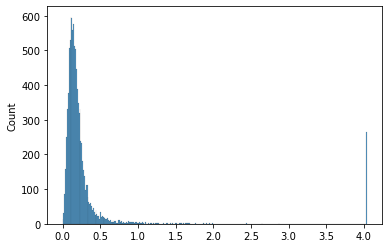

In [64]:
sns.histplot(divergences)

In [65]:
def fit_pair(J):
    S = eye(4)[::-1]
    PSP = S @ inv(J) @ S @ J
    _, P = eig(PSP.T)
    P = P.T
    P = diag(1/P.sum(axis=1)) @ P
    ix = zeros(4, dtype=int)
    ix[3] = norm(P - flip(P[0]), axis=1).argmin()
    ix[1:3] = list(set(range(4)) - {0, ix[3]})
    P = P[ix]
    Q = (J @ inv(P)).T
    pi = Q.sum(axis=1)
    Q = diag(1/pi) @ Q
    return regularize(Q), regularize(pi), regularize(P)

def regularize(P):
    P = P.real
    P[P < 0] = 0
    if len(P.shape) == 1:
        if not isclose(P.sum(), 1):
            P /= P.sum()
    else:
        if not allclose(P.sum(axis=1), 1):
            P = diag(1/P.sum(axis=1)) @ P
    return P

def fit_triple(Jab, Jbc, Jca):
    Pmb, pim, Pmc = fit_pair(Jbc)
    Jam = 0.5*(Jab @ inv(Pmb) + Jca.T @ inv(Pmc))
    Pra, pir, Prm = fit_pair(Jam)
    return Pra, pir, Prm, pim, Pmb, Pmc

Pra, pir, Prm, pim, Pmb, Pmc = fit_triple(J_ab, J_bc, J_ca)
for P in (Pra, Prm, Pmb, Pmc):
    assert allclose(P @ S, S @ P)
assert allclose(J_ab, Pra.T @ diag(pir) @ Prm @ Pmb)
assert allclose(J_bc, Pmb.T @ diag(pim) @ Pmc)
assert allclose(J_ca.T, Pra.T @ diag(pir) @ Prm @ Pmc)

In [66]:
def goodness_of_fit(Jab, Jbc, Jca, Pra, pir, Prm, pim, Pmb, Pmc):
    Jam = Pra.T @ diag(pir) @ Prm
    gab = rel_entr(Jab, Jam @ Pmb).sum()
    gbc = rel_entr(Jbc, Pmb.T @ diag(pim) @ Pmc).sum()
    gca = rel_entr(Jca.T, Jam @ Pmc).sum()
    return (gab + gbc + gca)/3

Pra, pir, Prm, pim, Pmb, Pmc = fit_triple(J_ab, J_bc, J_ca)
print('GoF a', goodness_of_fit(J_ab, J_bc, J_ca, Pra, pir, Prm, pim, Pmb, Pmc))
print('hat Prm')
print(Prm)
Pra, pir, Prm, pim, Pmb, Pmc = fit_triple(J_bc, J_ca, J_ab)
print('GoF b', goodness_of_fit(J_bc, J_ca, J_ab, Pra, pir, Prm, pim, Pmb, Pmc))
print('hat Prm')
print(Prm)
Pra, pir, Prm, pim, Pmb, Pmc = fit_triple(J_ca, J_ab, J_bc)
print('GoF c', goodness_of_fit(J_bc, J_ca, J_ab, Pra, pir, Prm, pim, Pmb, Pmc))
print('hat Prm')
print(Prm)

GoF a -1.9653649449720716e-17
hat Prm
[[0.0257507  0.02024715 0.87115553 0.08284662]
 [0.06548484 0.07848442 0.04399917 0.81203157]
 [0.81203157 0.04399917 0.07848442 0.06548484]
 [0.08284662 0.87115553 0.02024715 0.0257507 ]]
GoF b 0.023673869554789884
hat Prm
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]
GoF c 0.0735687650787256
hat Prm
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
